In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhiljohnk/tweets-with-sarcasm-and-irony")

print("Path to dataset files:", path)

100%|██████████| 4.27M/4.27M [00:00<00:00, 52.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhiljohnk/tweets-with-sarcasm-and-irony/versions/3


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd



In [3]:
# Load dataset
import os
dataset_path = path  # Path returned by kagglehub
csv_files = [f for f in os.listdir(dataset_path) if f.endswith(".csv")]

In [4]:
if csv_files:
    dataset_file = os.path.join(dataset_path, csv_files[0])  # Pick the first CSV file
    train_df = pd.read_csv(dataset_file)
    print(f"Loaded dataset: {dataset_file}")
else:
    raise FileNotFoundError("No CSV files found in the dataset folder.")


Loaded dataset: /root/.cache/kagglehub/datasets/nikhiljohnk/tweets-with-sarcasm-and-irony/versions/3/train.csv


In [5]:
# Encode labels
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])

In [6]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train_df["tweets"], train_df["label"], test_size=0.2, random_state=42, stratify=train_df["label"]
)

In [7]:
# Convert all values to strings and handle NaN values
X_train = X_train.astype(str).fillna("")
X_val = X_val.astype(str).fillna("")

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Adjust num_words as needed

# Convert all values to strings and handle NaN values
X_train = X_train.astype(str).fillna("")
X_val = X_val.astype(str).fillna("")

# Tokenization
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)



In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define max sequence length
max_seq_length = 50  # Adjust based on dataset

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length, padding="post", truncating="post")

# Convert labels to numpy arrays
y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()

print("Shapes:", X_train_pad.shape, y_train.shape)


Shapes: (65126, 50) (65126,)


In [9]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model

# Define parameters
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.3
max_vocab_size = 10000  # Define this before using in Embedding
max_seq_length = 50  # Ensure this is defined

# Model architecture
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_seq_length)(input_layer)
lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
context_rep = Bidirectional(LSTM(lstm_units))(lstm_out)
dropout = Dropout(dropout_rate)(context_rep)
out = Dense(4, activation='softmax')(dropout)  # Ensure '4' matches the number of classes

model = Model(inputs=input_layer, outputs=out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,478,148 (5.64 MB)

 Trainable params: 1,478,148 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# DCMG Model
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.3

input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_seq_length)(input_layer)
lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
context_rep = Bidirectional(LSTM(lstm_units))(lstm_out)
dropout = Dropout(dropout_rate)(context_rep)
out = Dense(4, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
y_train = y_train.ravel()
y_val = y_val.ravel()


In [12]:
print("Unique label values:", np.unique(y_train))
print("y_train dtype:", y_train.dtype)


Unique label values: [0 1 2 3]
y_train dtype: int64


In [13]:
out = Dense(4, activation='softmax')(dropout)  # 4 = number of classes


In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [15]:
# Check if '4' exists in y_train or y_val
if 4 in y_train or 4 in y_val:
    # Replace value '4' with value '3' in both y_train and y_val
    y_train = np.where(y_train == 4, 3, y_train)
    y_val = np.where(y_val == 4, 3, y_val)

In [16]:
# Train Model
model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=64)


Epoch 1/5
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 282s 269ms/step - accuracy: 0.6629 - loss: 0.6649 - val_accuracy: 0.7384 - val_loss: 0.4990
Epoch 2/5
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 322s 270ms/step - accuracy: 0.7398 - loss: 0.5009 - val_accuracy: 0.7381 - val_loss: 0.5018
Epoch 3/5
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 333s 280ms/step - accuracy: 0.7403 - loss: 0.4975 - val_accuracy: 0.7385 - val_loss: 0.4991
Epoch 4/5
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 311s 270ms/step - accuracy: 0.7382 - loss: 0.4969 - val_accuracy: 0.7363 - val_loss: 0.5092
Epoch 5/5
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 328s 276ms/step - accuracy: 0.7411 - loss: 0.4894 - val_accuracy: 0.7386 - val_loss: 0.5089


In [17]:
# Evaluate the model on validation/test data
loss, accuracy = model.evaluate(X_val_pad, y_val, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


509/509 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7436 - loss: 0.5037
Validation Accuracy: 73.86%


In [18]:
import numpy as np

# Get model predictions
y_pred = model.predict(X_val_pad)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Print some example predictions
for i in range(5):  # Show 5 sample predictions
    print(f"Text: {X_val.iloc[i]}")  # Use .iloc to access by position
    print(f"Actual Label: {y_val[i]}, Predicted Label: {y_pred_classes[i]}")
    print("-" * 50)

509/509 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step
Text: #POC #Drugs #of #Abuse #Testing Market|Size|Share|Trends|Forecast http://t.co/4agNRT7QJ0
Actual Label: 2, Predicted Label: 2
--------------------------------------------------
Text: LIVE on #Periscope: #Periscope #Katch #HowieMandel #Irony  https://t.co/vxrdcZvvxR
Actual Label: 1, Predicted Label: 1
--------------------------------------------------
Text: Twitter get a #sarcasm filter in its sponsor algorithm so U don't then get paid tweets from the thing U were making fun of in the 1st place.
Actual Label: 3, Predicted Label: 3
--------------------------------------------------
Text: 20 minute Seth Rollins promo again!!! I hate this #sarcasm
Actual Label: 3, Predicted Label: 3
--------------------------------------------------
Text: Everyone is searching something exceptional on internet.
Not for reading.
But for sharing.
#Irony
Actual Label: 1, Predicted Label: 1
--------------------------------------------------


In [19]:
import numpy as np
import pandas as pd

# Define class labels (modify as per your dataset)
class_labels = ["Not Sarcastic", "Sarcastic", "Irony", "Other"]  # Update if needed

# Compute label distribution in predictions
unique, counts = np.unique(y_pred_classes, return_counts=True)
label_counts = dict(zip(unique, counts))

# Convert to percentage
total = sum(label_counts.values())
label_percentages = {class_labels[k]: (v / total) * 100 for k, v in label_counts.items()}

# Print each label with its percentage
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Convert to DataFrame for visualization
df = pd.DataFrame(list(label_percentages.items()), columns=["Label", "Percentage"])



Not Sarcastic: 0.01%
Sarcastic: 38.76%
Irony: 22.88%
Other: 38.35%


<ipython-input-20-f6eabd690dca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Label"], y=df["Percentage"], palette="viridis")


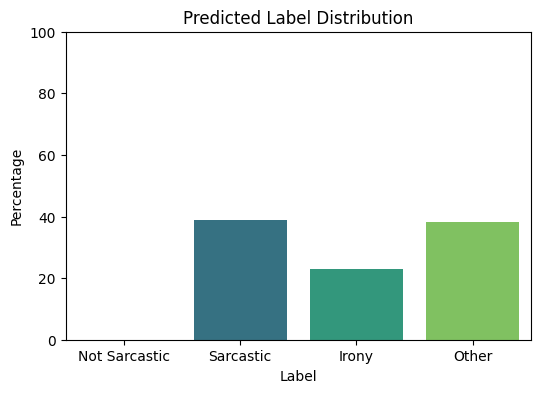

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot label distribution
plt.figure(figsize=(6,4))
sns.barplot(x=df["Label"], y=df["Percentage"], palette="viridis")
plt.ylabel("Percentage")
plt.title("Predicted Label Distribution")
plt.ylim(0, 100)  # Set y-axis from 0 to 100%
plt.show()


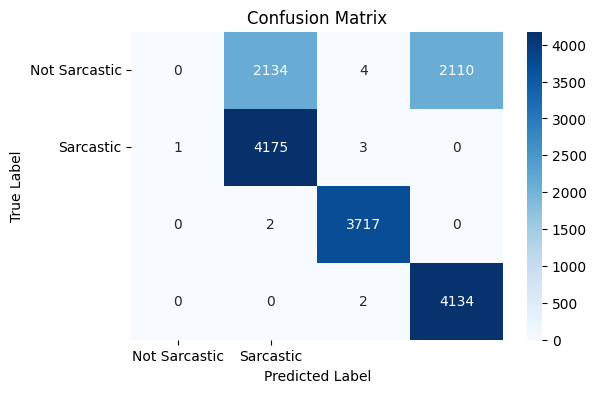

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Sarcastic", "Sarcastic"],
            yticklabels=["Not Sarcastic", "Sarcastic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
import pickle
import json

# Define filenames
model_filename = "sarcasm_dcmg_nb_model.keras"  # Changed extension to .keras
vectorizer_filename = "tfidf_vectorizer.pkl"
params_filename = "sarcasm_dcmg_params.json"

# Save the trained model using Keras's save method
model.save(model_filename)

# Save the TF-IDF vectorizer as a pickle file (if tfidf_vectorizer is defined)
try:
    with open(vectorizer_filename, "wb") as file:
        pickle.dump(tfidf_vectorizer, file)
except NameError:
    print("tfidf_vectorizer not found. Skipping saving vectorizer.")

# Save model configuration as a JSON file
model_config = model.to_json()
with open(params_filename, "w") as file:
    json.dump(model_config, file)

print("✅ Model, vectorizer (if defined), and parameters saved successfully!")

tfidf_vectorizer not found. Skipping saving vectorizer.
✅ Model, vectorizer (if defined), and parameters saved successfully!


In [23]:
from google.colab import files

# Download Pickle files and JSON file
files.download(model_filename)
files.download(vectorizer_filename)
files.download(params_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_pred_probs = model.predict(X_val_pad)
# Convert probabilities to class labels
y_pred = y_pred_probs.argmax(axis=1)

# Print precision, recall, f1-score
print(classification_report(y_val, y_pred))


509/509 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4248
           1       0.66      1.00      0.80      4179
           2       1.00      1.00      1.00      3719
           3       0.66      1.00      0.80      4136

    accuracy                           0.74     16282
   macro avg       0.58      0.75      0.65     16282
weighted avg       0.57      0.74      0.63     16282

